# Face Mask Detection
data from https://www.kaggle.com/datasets/andrewmvd/face-mask-detection/data

This dataset contains 853 images belonging to the 3 classes, as well as their bounding boxes in the PASCAL VOC format.
The classes are:

* 1. With mask
* 2. Without mask
* 3. Mask worn incorrectly

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mask-test/1.jpg
/kaggle/input/mask-test/4.jpg
/kaggle/input/mask-test/3.jpg
/kaggle/input/mask-test/2.jpg
/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask

In [2]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import glob
import yaml
import torch
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path
from sklearn.model_selection import train_test_split

## yolov8 [Github](https://github.com/ultralytics/ultralytics)

In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.4/709.4 kB 28.6 MB/s eta 0:00:00


## import yolo

In [4]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.1.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5432.0/8062.4 GB disk)


In [5]:
directory = "/kaggle/input/face-mask-detection"
image_directory = directory + "/images"
annotation_directory = directory + "/annotations"
annotations = list(Path(annotation_directory).glob(r'**/*{}'.format('xml')))

## 資料預處理

In [6]:
class_id = {
    "with_mask" : 0,
    "mask_weared_incorrect" : 1,
    "without_mask" : 2
}

data_dict = {
    'filename': [],
    'label': [],
    'class_id': [],
    'width': [],
    'height': [],
    'bboxes': []
}
for annotation_path in annotations:
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.findall("object"):
        label = obj.find("name").text
        
        bbox = []
        # bndbox has xmin, ymin, xmax, ymax
        bndbox_tree = obj.find('bndbox')
        bbox.append(int(bndbox_tree.find('xmin').text))
        bbox.append(int(bndbox_tree.find('ymin').text))
        bbox.append(int(bndbox_tree.find('xmax').text))
        bbox.append(int(bndbox_tree.find('ymax').text))
        size = root.find('size')
        
        data_dict['filename'].append(filename)
        data_dict['width'].append(int(size.find('width').text))
        data_dict['height'].append(int(size.find('height').text))
        data_dict['label'].append(label)
        data_dict['class_id'].append(class_id[label])
        data_dict['bboxes'].append(bbox)

df_data = pd.DataFrame(data_dict)

df_data.head()

filename                  label  class_id  width  height  \
0  maksssksksss737.png              with_mask         0    400     226   
1  maksssksksss737.png              with_mask         0    400     226   
2  maksssksksss737.png  mask_weared_incorrect         1    400     226   
3  maksssksksss737.png              with_mask         0    400     226   
4  maksssksksss737.png              with_mask         0    400     226   

               bboxes  
0    [28, 55, 46, 71]  
1   [98, 62, 111, 78]  
2  [159, 50, 193, 90]  
3  [293, 59, 313, 80]  
4  [352, 51, 372, 72]

In [7]:
df_data.isna().sum() #查看缺失值

filename    0
label       0
class_id    0
width       0
height      0
bboxes      0
dtype: int64

In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   label     4072 non-null   object
 2   class_id  4072 non-null   int64 
 3   width     4072 non-null   int64 
 4   height    4072 non-null   int64 
 5   bboxes    4072 non-null   object
dtypes: int64(3), object(3)
memory usage: 191.0+ KB


In [9]:
df_data.label.unique()

array(['with_mask', 'mask_weared_incorrect', 'without_mask'], dtype=object)

In [10]:
print(f"Total 'without_mask' labels: {sum(df_data.label == 'without_mask')}")
print(f"Total 'mask_weared_incorrect' labels: {sum(df_data.label == 'mask_weared_incorrect')}")
print(f"Total 'with_mask' labels: {sum(df_data.label == 'with_mask')}")

Total 'without_mask' labels: 717
Total 'mask_weared_incorrect' labels: 123
Total 'with_mask' labels: 3232


## 資料視覺化

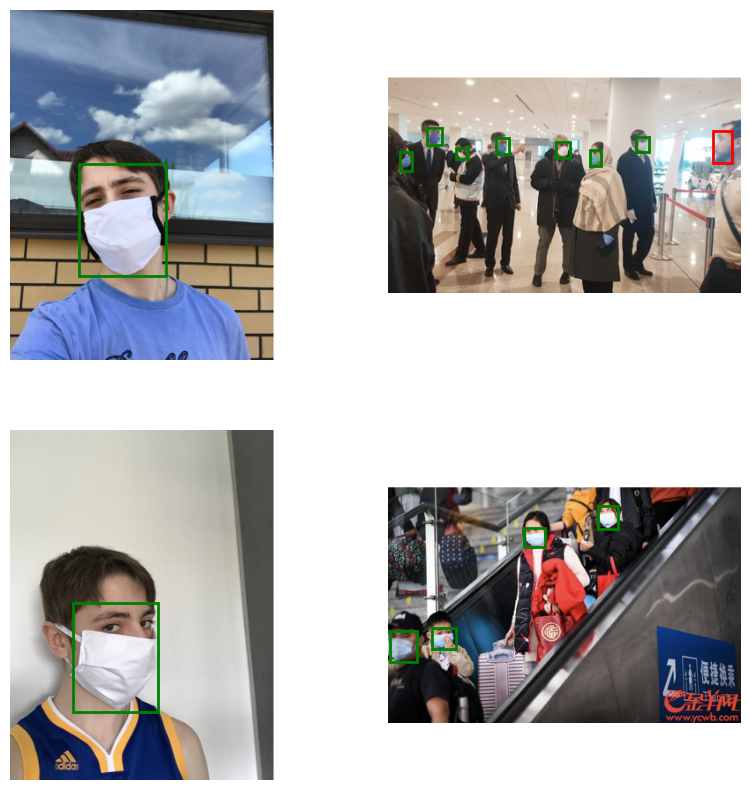

In [11]:
def show_random_images_with_bbox(df):
    all_images = os.listdir(image_directory)
    random_image_filename = random.sample(all_images, 4)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    for i, filename in enumerate(random_image_filename):
        selected_df = df[df['filename'] == filename]
        
        image = Image.open(image_directory + '/' + filename)
        
        ax.flat[i].imshow(image)
        ax.flat[i].axis(False)
        
        image_bboxes = []
        for df_index in range(0, len(selected_df)):
            color = "g"
            if selected_df.iloc[df_index].class_id == 1: color = "y"
            elif selected_df.iloc[df_index].class_id == 2: color = "r"
            
            x_min, y_min, x_max, y_max = selected_df.iloc[df_index].bboxes
            
            rect = patches.Rectangle([x_min, y_min], x_max-x_min, y_max-y_min, 
                             linewidth=2, edgecolor=color, facecolor="none")
            ax.flat[i].add_patch(rect)
            
show_random_images_with_bbox(df_data)

In [12]:
# we need to convert our bbox format to yolo as the current one that we have is on pascal_voc
def pascal_voc_to_yolo_bbox(bbox_array, w, h):
    x_min, y_min, x_max, y_max = bbox_array
    
    x_center = ((x_max + x_min) / 2) / w
    y_center = ((y_max + y_min) / 2) / h
    
    width = (x_max - x_min) / w
    height = (y_max - y_min) / h
    
    return [x_center, y_center, width, height]

## 分割 train / val / test data

In [13]:
train_path = "/kaggle/working/datasets/train"
valid_path = "/kaggle/working/datasets/valid"
test_path = "/kaggle/working/datasets/test"

os.mkdir("/kaggle/working/datasets")
os.mkdir(train_path)
os.mkdir(valid_path)
os.mkdir(test_path)

In [14]:
train, test = train_test_split(df_data.filename.unique(), test_size=0.2, random_state=23)
train, valid = train_test_split(train, test_size=0.15, random_state=23)

def copy_image_file(image_items, folder_name):
    for image in image_items:
            image_path = image_directory + "/" + image
            new_image_path = os.path.join(folder_name, image)
            shutil.copy(image_path, new_image_path)

def create_label_file(image_items, folder_name):
    for image in image_items:
        fileName = Path(image).stem
        df = df_data[df_data['filename'] == image]
        with open(folder_name + "/" + fileName +'.txt', 'w') as f:
            for i in range(0, len(df)):
                bbox = pascal_voc_to_yolo_bbox(df.iloc[i]['bboxes'], df.iloc[i]['width'], df.iloc[i]['height'])
                bbox_text = " ".join(map(str, bbox))
                txt = str(df.iloc[i]['class_id'])+ " " + bbox_text
                f.write(txt)
                if i != len(df) - 1:
                    f.write("\n")
                

copy_image_file(train, train_path)
copy_image_file(valid, valid_path)
copy_image_file(test, test_path)

create_label_file(train, train_path)
create_label_file(valid, valid_path)
create_label_file(test, test_path)

In [15]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(glob.glob(filepath + '/*.png', recursive = True))} images in '{dirpath}'.")
    
walk_through_dir(train_path)
walk_through_dir(valid_path)  
walk_through_dir(test_path)  

There are 0 directories and 579 images in '/kaggle/working/datasets/train'.
There are 0 directories and 103 images in '/kaggle/working/datasets/valid'.
There are 0 directories and 171 images in '/kaggle/working/datasets/test'.


## Create YAML file

In [16]:
classes = list(df_data.label.unique())
class_count = len(classes)
facemask_yaml = f"""
    train: train
    val: valid
    test: test
    nc: {class_count}
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    """

with open('facemask.yaml', 'w') as f:
    f.write(facemask_yaml)
    
%cat facemask.yaml


    train: train
    val: valid
    test: test
    nc: 3
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    

## Train

In [17]:
model = YOLO("yolov8n.pt") 
model.train(data="facemask.yaml", epochs=50)

100%|██████████| 6.23M/6.23M [00:00<00:00, 162MB/s]

Ultralytics YOLOv8.1.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=facemask.yaml, epochs=50, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dynamic=Fal

100%|██████████| 755k/755k [00:00<00:00, 37.7MB/s]
2024-02-07 10:17:40,883	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-07 10:17:41,689	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-07 10:17:44.288785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 10:17:44.288887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 10:17:44.436353: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS facto

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/datasets/train... 579 images, 0 backgrounds, 0 corrupt: 100%|██████████| 579/579 [00:01<00:00, 470.45it/s]

train: New cache created: /kaggle/working/datasets/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/datasets/valid...:   0%|          | 0/103 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
val: Scanning /kaggle/working/datasets/valid... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<00:00, 568.88it/s]

val: New cache created: /kaggle/working/datasets/valid.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.55G      1.899      3.045      1.484        127        640:  81%|████████  | 30/37 [00:11<00:01,  4.79it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       1/50      2.57G      1.818      2.798      1.414         33        640: 100%|██████████| 37/37 [00:12<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]

                   all        103        559     0.0114      0.442      0.188      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.63G       1.33      1.505      1.092         27        640: 100%|██████████| 37/37 [00:07<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

                   all        103        559      0.818      0.135      0.196      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.37G      1.295      1.299      1.071         98        640:  57%|█████▋    | 21/37 [00:04<00:03,  4.58it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       3/50       2.4G      1.309      1.297      1.074         57        640: 100%|██████████| 37/37 [00:07<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]

                   all        103        559      0.581      0.364      0.437       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.53G      1.289      1.168      1.058         58        640: 100%|██████████| 37/37 [00:07<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.32it/s]

                   all        103        559      0.879      0.418      0.512      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/37 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       5/50      2.63G      1.222      1.084      1.039         22        640: 100%|██████████| 37/37 [00:07<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.32it/s]

                   all        103        559      0.508       0.49      0.483      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.37G      1.218      1.043      1.042        120        640:  54%|█████▍    | 20/37 [00:03<00:03,  4.78it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       6/50      2.41G      1.198      1.025      1.035         33        640: 100%|██████████| 37/37 [00:07<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]

                   all        103        559       0.74      0.546      0.628      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.46G      1.249      1.054      1.046         71        640:  16%|█▌        | 6/37 [00:01<00:06,  5.06it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       7/50      2.46G       1.22      1.009      1.036        162        640:  92%|█████████▏| 34/37 [00:06<00:00,  5.05it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       7/50      2.49G      1.217          1       1.04         25        640: 100%|██████████| 37/37 [00:07<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.47it/s]

                   all        103        559      0.762      0.549      0.623      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.41G      1.161     0.9307      1.026         41        640: 100%|██████████| 37/37 [00:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

                   all        103        559      0.726      0.587      0.627      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.41G      1.145     0.8761      1.012         79        640:  30%|██▉       | 11/37 [00:02<00:05,  4.89it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       9/50      2.44G      1.161     0.8734      1.015         10        640: 100%|██████████| 37/37 [00:07<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

                   all        103        559      0.654      0.598      0.605      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.33G      1.152     0.8776       1.03        111        640:  49%|████▊     | 18/37 [00:03<00:04,  4.52it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      10/50      2.36G      1.155     0.8744      1.021         38        640: 100%|██████████| 37/37 [00:07<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        103        559      0.883      0.565       0.63      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.63G      1.146     0.8464      1.013         21        640: 100%|██████████| 37/37 [00:07<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]

                   all        103        559      0.777      0.635      0.658      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.51G      1.138     0.8078     0.9992        130        640:  35%|███▌      | 13/37 [00:02<00:04,  4.99it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      12/50      2.53G      1.133     0.8002     0.9928         42        640: 100%|██████████| 37/37 [00:07<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

                   all        103        559      0.794      0.636      0.671      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.33G       1.11     0.7775      1.009         87        640:  68%|██████▊   | 25/37 [00:04<00:02,  5.12it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      13/50      2.36G      1.132     0.7633      1.009         32        640: 100%|██████████| 37/37 [00:07<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

                   all        103        559       0.65      0.609      0.603      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.54G      1.105     0.7773      1.004         16        640: 100%|██████████| 37/37 [00:07<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        103        559      0.777      0.662      0.709      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.39G      1.086     0.7552       1.01        108        640:  14%|█▎        | 5/37 [00:01<00:07,  4.43it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      15/50      2.42G      1.107     0.7494     0.9996         23        640: 100%|██████████| 37/37 [00:07<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]

                   all        103        559      0.645       0.64      0.661      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.33G      1.113      0.753     0.9963        132        640:  70%|███████   | 26/37 [00:05<00:02,  4.55it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      16/50      2.35G      1.099     0.7362     0.9942         23        640: 100%|██████████| 37/37 [00:08<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all        103        559      0.912      0.638      0.692      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.41G      1.107      0.708     0.9964        100        640:  16%|█▌        | 6/37 [00:01<00:06,  5.16it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      17/50      2.43G      1.109     0.7043     0.9952         84        640: 100%|██████████| 37/37 [00:07<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

                   all        103        559      0.816      0.667      0.688      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.32G     0.9529     0.6802     0.9479        105        640:   3%|▎         | 1/37 [00:00<00:05,  6.05it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      18/50      2.54G      1.072     0.7073     0.9818        108        640:  84%|████████▍ | 31/37 [00:06<00:01,  4.74it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      18/50      2.57G      1.078     0.7143     0.9819         28        640: 100%|██████████| 37/37 [00:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]

                   all        103        559      0.797      0.676      0.701      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.38G      1.117     0.7187      1.001        123        640:  86%|████████▋ | 32/37 [00:06<00:00,  5.33it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      19/50      2.42G      1.114     0.7151     0.9996         20        640: 100%|██████████| 37/37 [00:07<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.61it/s]

                   all        103        559      0.781      0.673      0.723      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.48G      1.072     0.6835     0.9873        121        640:  95%|█████████▍| 35/37 [00:06<00:00,  5.45it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      20/50       2.5G      1.069     0.6806     0.9872         22        640: 100%|██████████| 37/37 [00:07<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

                   all        103        559      0.869      0.686      0.739      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.54G      1.048     0.6685      0.983         12        640: 100%|██████████| 37/37 [00:07<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]

                   all        103        559      0.884      0.653      0.711      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.38G      1.064     0.6723     0.9825        107        640:  59%|█████▉    | 22/37 [00:04<00:03,  4.76it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      22/50      2.84G      1.054     0.6718     0.9761        245        640:  97%|█████████▋| 36/37 [00:07<00:00,  5.01it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      22/50      2.87G      1.057      0.673     0.9747         54        640: 100%|██████████| 37/37 [00:07<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

                   all        103        559      0.747      0.697      0.707      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.49G      1.062      0.677     0.9841         74        640: 100%|██████████| 37/37 [00:07<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

                   all        103        559      0.874       0.63      0.703       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.33G      1.004      0.654     0.9922        134        640:  19%|█▉        | 7/37 [00:01<00:05,  5.40it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      24/50      2.35G       1.04     0.6544     0.9831         22        640: 100%|██████████| 37/37 [00:07<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

                   all        103        559      0.768      0.626      0.682      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.33G      1.061     0.6392     0.9731         94        640:  70%|███████   | 26/37 [00:05<00:02,  4.85it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      25/50      2.36G      1.051      0.642     0.9716         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.57it/s]

                   all        103        559      0.793      0.688      0.715      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.36G      1.022      0.643     0.9643         11        640: 100%|██████████| 37/37 [00:07<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

                   all        103        559      0.851       0.71      0.744      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.57G      1.049     0.6476     0.9671         87        640:  70%|███████   | 26/37 [00:05<00:02,  4.70it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      27/50       2.6G      1.032     0.6433     0.9649          7        640: 100%|██████████| 37/37 [00:07<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        103        559      0.912      0.575      0.705      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.48G      1.049     0.6476     0.9648        126        640:  65%|██████▍   | 24/37 [00:04<00:02,  4.85it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      28/50       2.5G      1.038     0.6451     0.9614         57        640: 100%|██████████| 37/37 [00:07<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]

                   all        103        559      0.767      0.672      0.689      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.37G      1.023     0.6349     0.9861         77        640:  57%|█████▋    | 21/37 [00:04<00:03,  5.31it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      29/50      2.56G      1.012     0.6208     0.9734         25        640: 100%|██████████| 37/37 [00:07<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

                   all        103        559      0.802      0.719      0.744      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.37G       1.02     0.5908     0.9581         92        640:  19%|█▉        | 7/37 [00:01<00:05,  5.07it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      30/50      2.56G      1.024     0.6005      0.951         51        640: 100%|██████████| 37/37 [00:07<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

                   all        103        559      0.799      0.676      0.734      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.39G      1.054     0.6052     0.9703         91        640:  46%|████▌     | 17/37 [00:03<00:04,  4.89it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      31/50      2.43G      1.034     0.6053     0.9639          6        640: 100%|██████████| 37/37 [00:07<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]

                   all        103        559      0.888        0.7      0.753      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.55G      1.012     0.5768     0.9535        121        640:  46%|████▌     | 17/37 [00:03<00:04,  4.28it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      32/50       2.8G      1.007      0.587     0.9491        108        640:  97%|█████████▋| 36/37 [00:07<00:00,  4.78it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      32/50      2.82G      1.004     0.5858     0.9469         14        640: 100%|██████████| 37/37 [00:07<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

                   all        103        559      0.906      0.718       0.77      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.56G      0.964     0.5607     0.9483          6        640: 100%|██████████| 37/37 [00:07<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

                   all        103        559      0.882      0.719      0.757      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.32G     0.8783     0.5832     0.9614         76        640:   3%|▎         | 1/37 [00:00<00:05,  6.10it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      34/50      2.51G      0.977     0.5766     0.9475         18        640: 100%|██████████| 37/37 [00:07<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 1/4 [00:00<00:00,  4.01it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

                   all        103        559      0.898      0.701      0.761      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.43G     0.9989     0.5726     0.9431         25        640: 100%|██████████| 37/37 [00:07<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

                   all        103        559      0.893      0.709      0.766      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.54G     0.9764     0.5716     0.9455         19        640: 100%|██████████| 37/37 [00:07<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]

                   all        103        559      0.891      0.686      0.768      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.51G     0.9725     0.5618     0.9261        168        640:  27%|██▋       | 10/37 [00:01<00:05,  5.08it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      37/50      2.54G     0.9584     0.5526     0.9368         36        640: 100%|██████████| 37/37 [00:07<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        103        559      0.936      0.717      0.772      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.55G       0.97     0.5461     0.9369        207        640:  54%|█████▍    | 20/37 [00:03<00:03,  4.87it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      38/50      2.59G      0.951     0.5393       0.94         27        640: 100%|██████████| 37/37 [00:07<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        103        559       0.91      0.712      0.761      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.37G      0.914     0.5326       0.94        109        640:  49%|████▊     | 18/37 [00:03<00:04,  4.55it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      39/50      2.41G      0.926     0.5412     0.9445         10        640: 100%|██████████| 37/37 [00:07<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

                   all        103        559      0.897      0.739       0.78      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.39G     0.9177       0.53     0.9356        106        640:  70%|███████   | 26/37 [00:05<00:02,  5.07it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      40/50      2.41G     0.9307     0.5358     0.9377         29        640: 100%|██████████| 37/37 [00:07<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

                   all        103        559      0.903      0.744      0.784      0.504


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.33G     0.9425       0.56     0.9375         93        640:  19%|█▉        | 7/37 [00:03<00:10,  2.78it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      41/50      2.33G     0.9331     0.5253     0.9283         54        640:  86%|████████▋ | 32/37 [00:08<00:01,  4.85it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      41/50      2.36G     0.9337     0.5261     0.9229         53        640: 100%|██████████| 37/37 [00:09<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]

                   all        103        559      0.902      0.695      0.765      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.54G     0.9222      0.502     0.9197          3        640: 100%|██████████| 37/37 [00:07<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        103        559      0.893       0.69      0.768      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.38G     0.9136     0.4949     0.9228         74        640:  46%|████▌     | 17/37 [00:03<00:04,  4.86it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      43/50      2.38G     0.9257     0.4988      0.926         69        640:  89%|████████▉ | 33/37 [00:06<00:00,  5.15it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      43/50      2.41G     0.9249     0.4981     0.9239         11        640: 100%|██████████| 37/37 [00:07<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.19it/s]

                   all        103        559      0.898      0.717      0.782      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.53G     0.9091     0.4942     0.9109         39        640: 100%|██████████| 37/37 [00:06<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

                   all        103        559      0.919      0.704      0.785       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.41G     0.8955      0.482     0.9202         53        640:  68%|██████▊   | 25/37 [00:04<00:02,  4.88it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      45/50      2.44G     0.8915     0.4803     0.9191         12        640: 100%|██████████| 37/37 [00:07<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

                   all        103        559      0.862      0.702      0.755      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.33G     0.9004     0.4932      0.903         66        640:  27%|██▋       | 10/37 [00:01<00:05,  5.27it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      46/50      2.53G     0.9006     0.4894     0.9145         44        640: 100%|██████████| 37/37 [00:07<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

                   all        103        559      0.934      0.684       0.77      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.51G     0.8934     0.4717     0.9077         27        640: 100%|██████████| 37/37 [00:07<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        103        559      0.844      0.722      0.787      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.51G     0.8842     0.4533     0.9078         77        640:  76%|███████▌  | 28/37 [00:05<00:01,  4.83it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      48/50      2.53G     0.8866     0.4583     0.9139         17        640: 100%|██████████| 37/37 [00:06<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]

                   all        103        559      0.897      0.695      0.783      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.54G     0.8652     0.4499     0.9024         18        640: 100%|██████████| 37/37 [00:07<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        103        559      0.888      0.695      0.772      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.33G     0.8445     0.4391     0.9052        106        640:  27%|██▋       | 10/37 [00:01<00:05,  5.08it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      50/50      2.36G     0.8535     0.4504     0.9027          3        640: 100%|██████████| 37/37 [00:07<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]

                   all        103        559      0.896      0.703      0.771      0.509



50 epochs completed in 0.134 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


                   all        103        559      0.844      0.722      0.786      0.521
             with_mask        103        463      0.929      0.909      0.939      0.613
 mask_weared_incorrect        103         14      0.778        0.5       0.63      0.453
          without_mask        103         82      0.824      0.756      0.789      0.498
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ded220de170>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

## Val

In [18]:
model.val(data="facemask.yaml")

Ultralytics YOLOv8.1.10 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/datasets/valid.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]


                   all        103        559      0.845      0.723      0.788      0.524
             with_mask        103        463      0.934      0.911       0.94      0.614
 mask_weared_incorrect        103         14      0.778        0.5      0.635      0.459
          without_mask        103         82      0.824      0.756       0.79        0.5
Speed: 0.1ms preprocess, 33.0ms inference, 0.0ms loss, 21.6ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7decf92a4610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

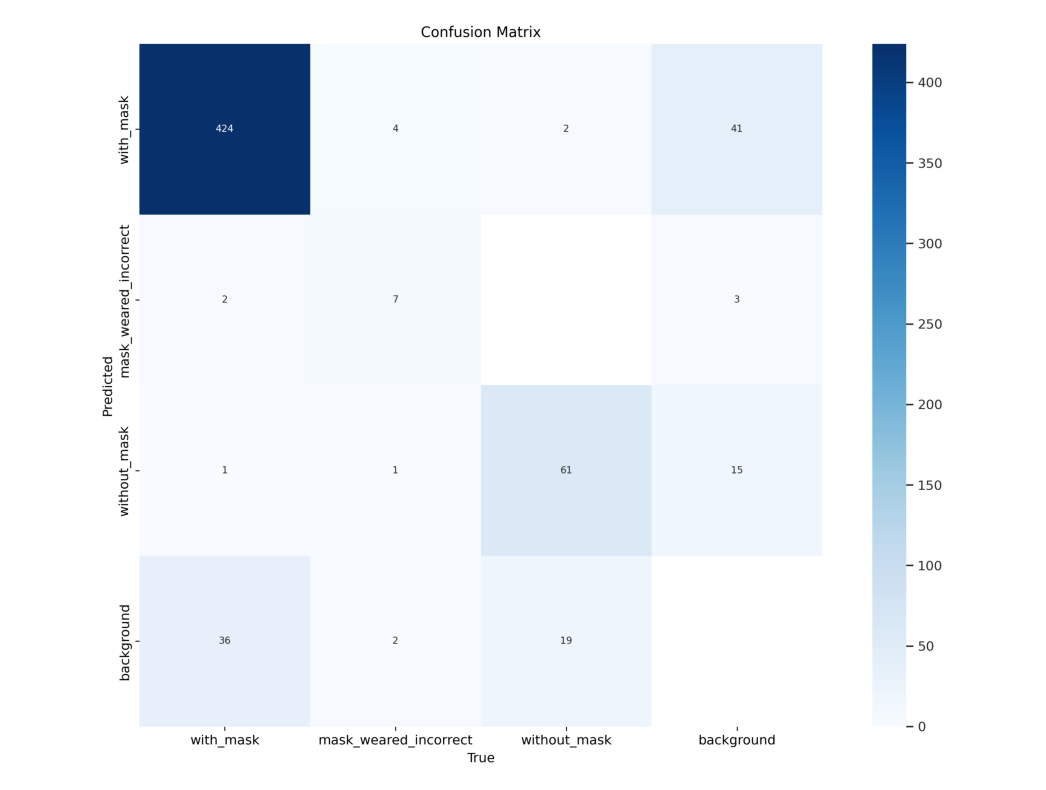

In [19]:
confusion_matrix = Image.open("/kaggle/working/runs/detect/train/confusion_matrix.png")
plt.figure(figsize=(20,10))
plt.imshow(confusion_matrix)
plt.axis(False)
plt.show()

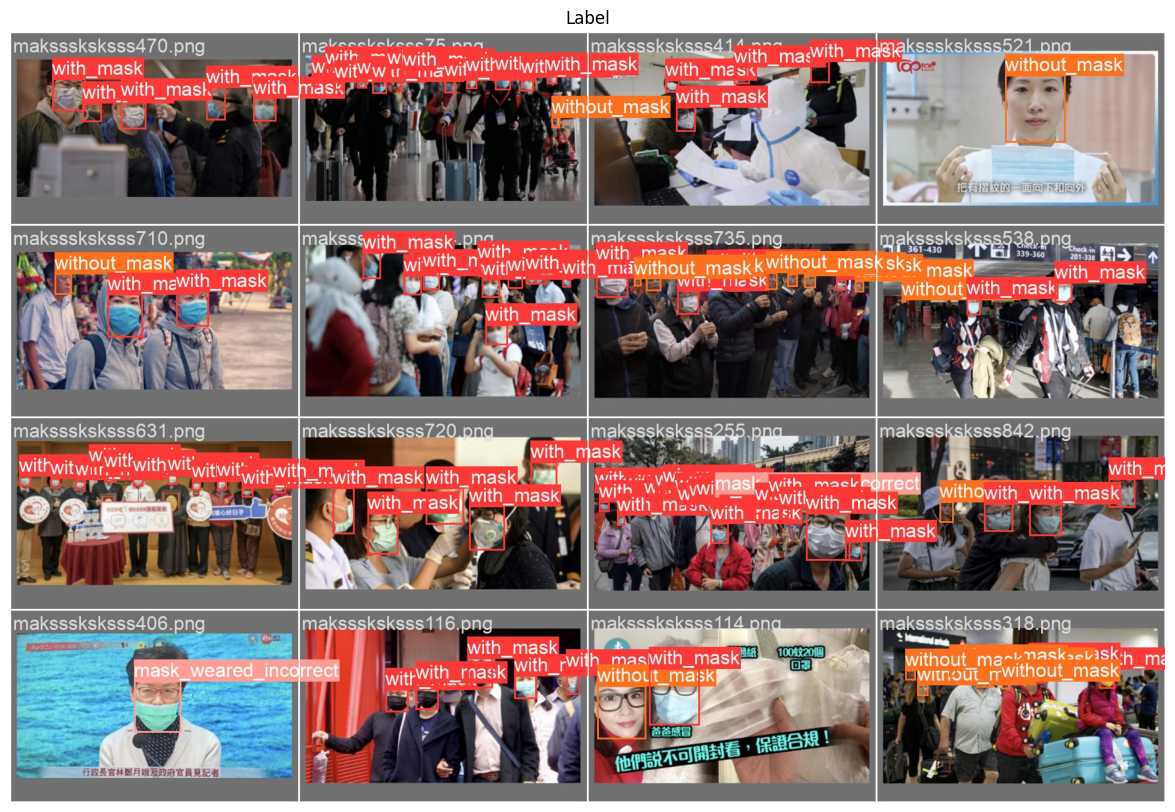

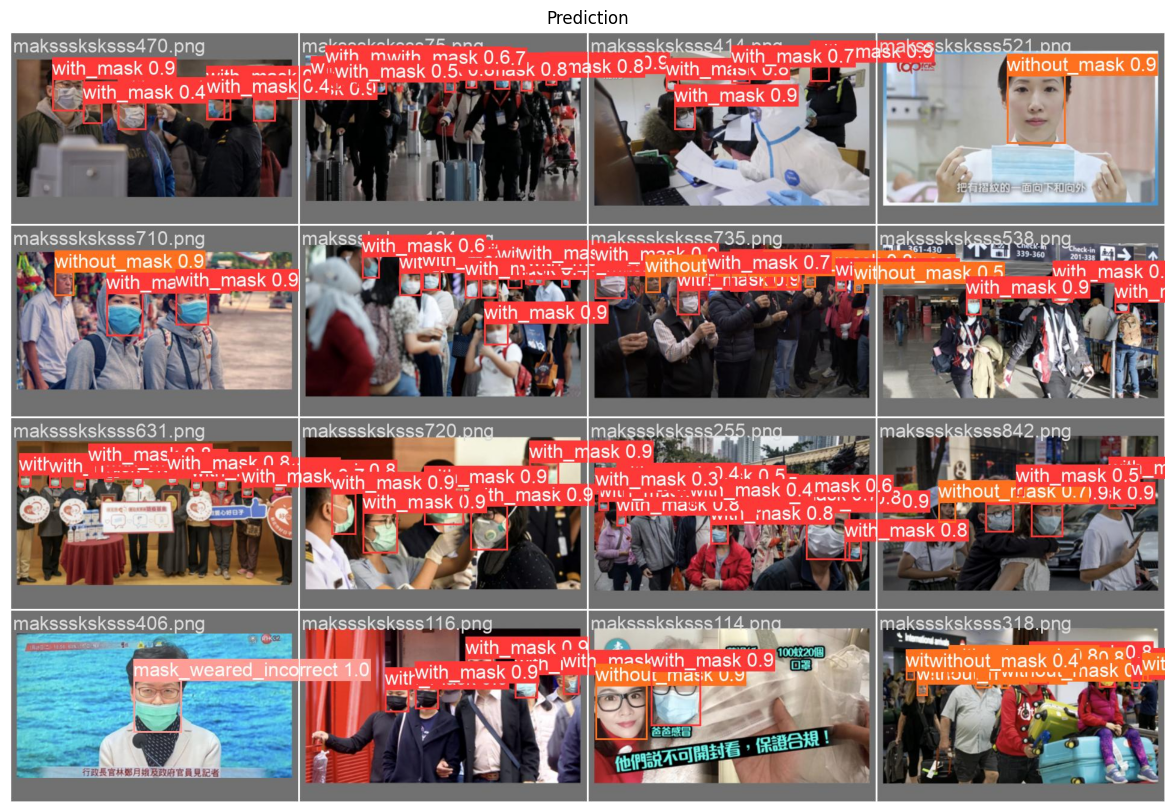

In [20]:
val_label = Image.open("/kaggle/working/runs/detect/train/val_batch0_labels.jpg")
val_pred = Image.open("/kaggle/working/runs/detect/train/val_batch0_pred.jpg")

plt.figure(figsize=(20,10))
plt.imshow(val_label)
plt.title("Label")
plt.axis(False)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(val_pred)
plt.title("Prediction")
plt.axis(False)
plt.show()

## Predict

In [21]:
model = YOLO(model="/kaggle/working/runs/detect/train/weights/best.pt")

In [22]:
filenames = glob.glob("/kaggle/input/mask-test/"+"*.jpg", recursive=False)
test_image0 = cv2.imread(filenames[0])
test_image1 = cv2.imread(filenames[1])
test_image2 = cv2.imread(filenames[2])
test_image3 = cv2.imread(filenames[3])

results = model.predict([test_image0, test_image1, test_image2, test_image3], save=True, line_thickness=1)


WARNING ⚠️ 'line_thickness' is deprecated and will be removed in 'ultralytics 8.299999999999999' in the future. Please use 'line_width' instead.

0: 640x640 2 without_masks, 1: 640x640 3 with_masks, 2: 640x640 3 with_masks, 1 without_mask, 3: 640x640 1 with_mask, 1 without_mask, 66.8ms
Speed: 2.5ms preprocess, 16.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


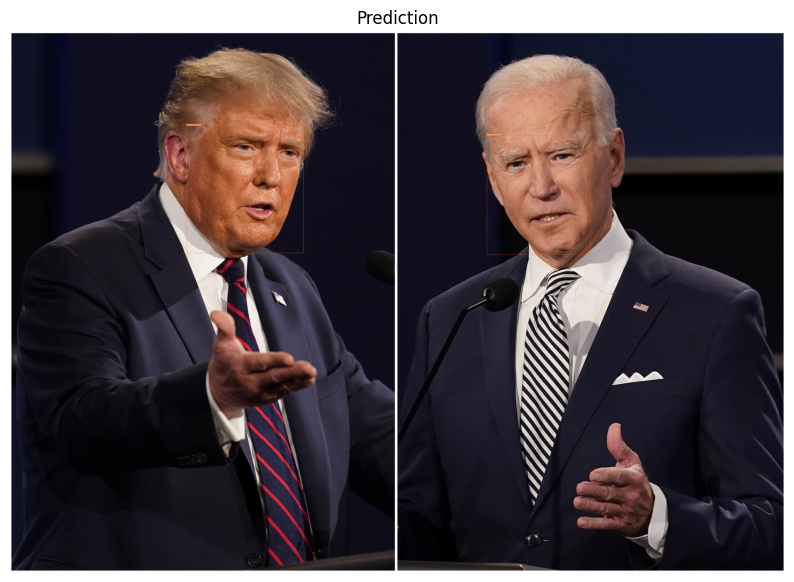

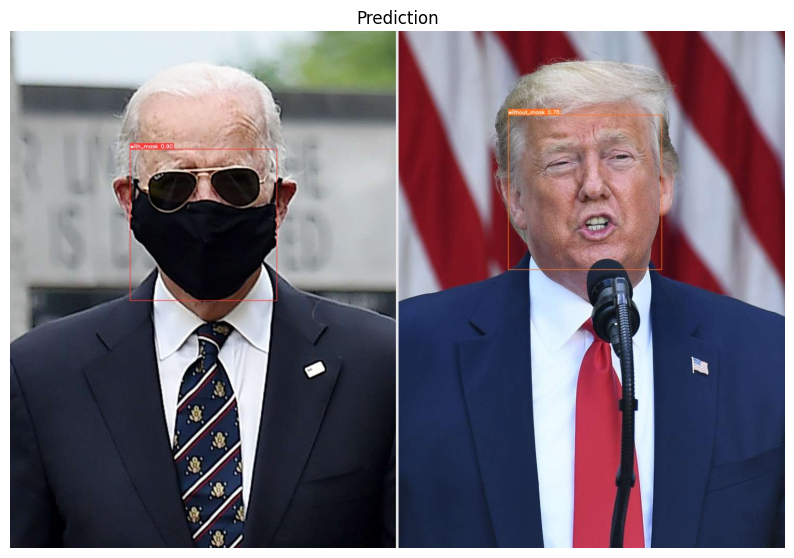

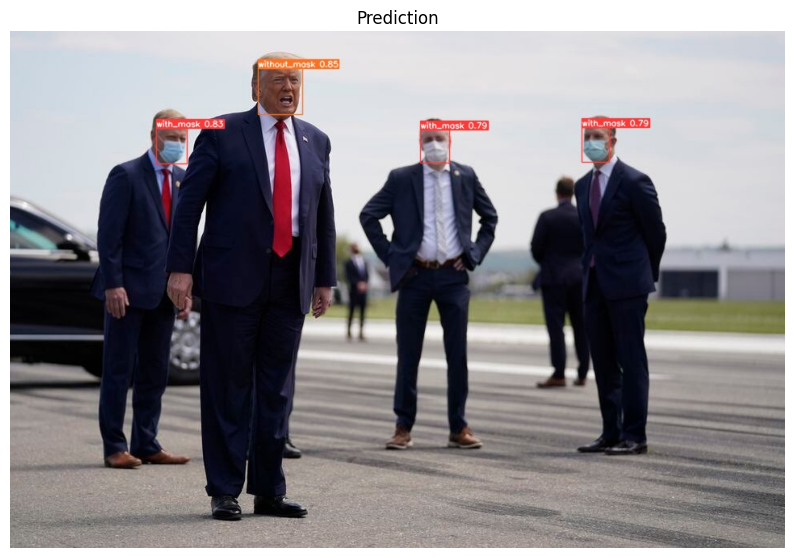

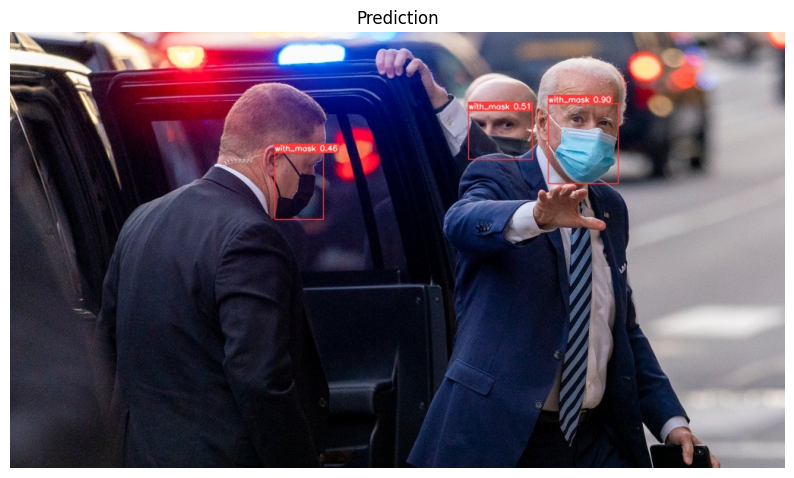

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
import glob

image_files = glob.glob("runs/detect/predict/*.jpg")

for image_file in image_files:
    predicted_image = Image.open(image_file)
    plt.figure(figsize=(10, 10))
    plt.imshow(predicted_image)
    plt.title("Prediction")
    plt.axis(False)
    plt.show()


# 結論
### with_mask 的準確率比 without_mask / Mask worn incorrectly 來的高
### (原因可能來自dataset數量差異)